<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/All_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cashflow Analysis**

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def preprocess_data(data):
  # Membaca file dataset
  data = pd.DataFrame(pd.read_json(data))

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  return summary

In [ ]:
preprocess_data('merger_dataset.json')

,month,total_income,total_expense,net_cashflow
0,2023-08,1390000,1412950,-22950
1,2023-09,1607000,1443530,163470
2,2023-10,1510000,1652785,-142785
3,2023-11,1200000,1077068,122932
4,2023-12,1750000,1829508,-79508
5,2024-01,9735000,11400361,-1665361
6,2024-02,19201015,18971500,229515
7,2024-03,3620000,2670818,949182
8,2024-04,6250101,4098822,2151279
9,2024-05,4527000,6434944,-1907944


In [ ]:
#Min-Max Scaler Initialization
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = scaler.fit_transform(data[['total_income']])
  total_expense = scaler.fit_transform(data[['total_expense']])
  net_cashflow = scaler.fit_transform(data[['net_cashflow']])

  # Assign value variabel time dan series
  time = pd.to_datetime(data['month'].astype(str)).tolist()
  income = data['total_income'].tolist()
  expense = data['total_expense'].tolist()
  net_cashflow = data['net_cashflow'].tolist()

  return time, income, expense, net_cashflow

In [ ]:
DATA = 'merger_dataset.json'
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(preprocess_data(DATA))

INCOME_SCALED = scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [ ]:
#Visualisasi Data

def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gcf().autofmt_xdate()
  plt.show()

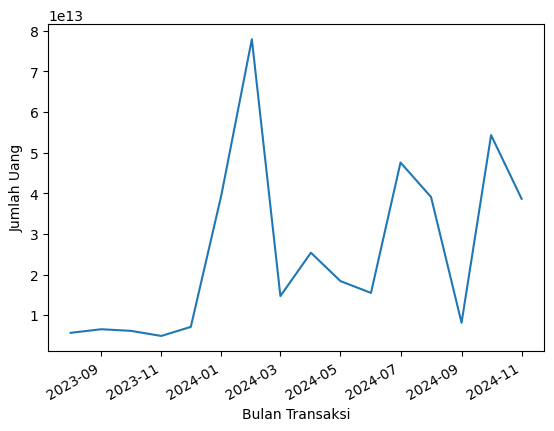

In [ ]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

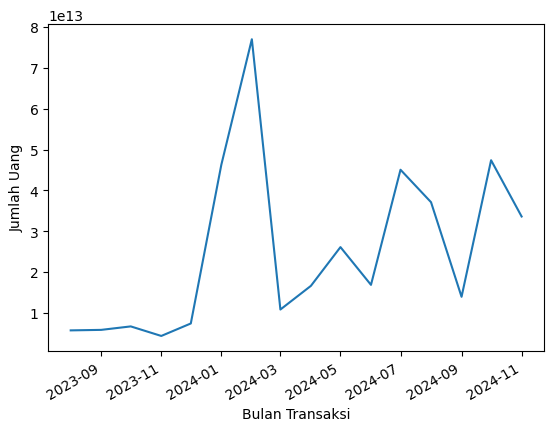

In [ ]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

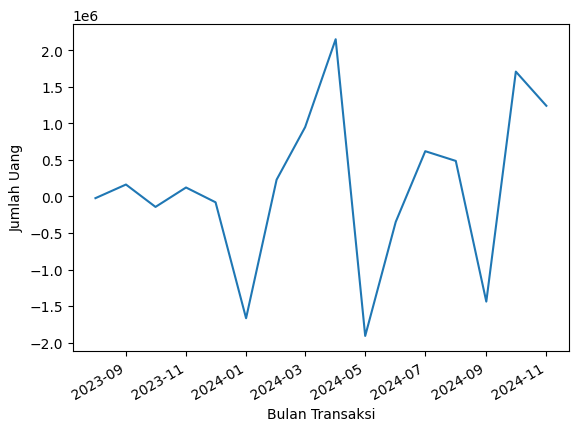

In [ ]:
plot_value(TIME, NET_CASHFLOW, "Net Cashflow")

In [ ]:
# Format data JSON
data_for_export = {
  "cashflow_analysis": [
    {
      "time": TIME[i].strftime('%Y-%m'),
      "total_income": INCOME[i],
      "total_expense": EXPENSE[i],
      "net_cashflow": NET_CASHFLOW[i]
    }
    for i in range(len(TIME))
  ]
}

# Simpan ke JSON
with open('clean_data.json', 'w') as json_file:
    json.dump(data_for_export, json_file, indent=1)

# **Anomaly Detection**

In [142]:
import json
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

In [143]:
def load_data(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    # Extract numerical data for each time period
    numerical_data = []
    for entry in data['cashflow_analysis']:
        numerical_data.append([
            entry['total_income'],
            entry['total_expense'],
            entry['net_cashflow']
        ])

    # Convert to NumPy array
    return np.array(numerical_data)

In [144]:
def find_closest_centroids(X, centroids):
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        # Array to hold distance between X[i] and each centroids[j]
        distance = []
        for j in range(centroids.shape[0]):
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)

        idx[i] = np.argmin(distance)

    return idx

In [145]:
# Load an example dataset that we will be using
X = load_data('clean_data.json')

In [146]:
print("First five elements of X are:\n", X[:5])
print('The shape of X is:', X.shape)

First five elements of X are:
 [[1390000 1412950  -22950]
 [1607000 1443530  163470]
 [1510000 1652785 -142785]
 [1200000 1077068  122932]
 [1750000 1829508  -79508]]
The shape of X is: (16, 3)


In [147]:
# Select an initial set of centroids (3 Centroids) with 3 features to match the data
initial_centroids = np.array([[3, 4, 5], [6, 7, 8], [8, 7, 6]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])

First three elements in idx are: [2 2 2]


In [148]:
import numpy as np

def compute_centroids(X, idx, K):
    m, n = X.shape  # Number of examples and features
    centroids = np.zeros((K, n))

    for k in range(K):
        # Get all points assigned to cluster k
        points_in_cluster = X[idx == k]

        # Calculate the mean of these points to get the new centroid
        if len(points_in_cluster) > 0:  # Avoid division by zero if cluster is empty
            centroids[k] = np.mean(points_in_cluster, axis=0)

    return centroids

In [149]:
K = 3
centroids = compute_centroids(X, idx, K)

print("The centroids are:", centroids)

The centroids are: [[      0.           0.           0.    ]
 [      0.           0.           0.    ]
 [6303266.125  6174115.9375  129150.1875]]


In [150]:
def plot_progress_kMeans(X, centroids, previous, idx, K, i):
    # Plot the examples
    plot_data_points(X, idx, K)

    # Plot the centroids as black X's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', s=20, linewidth=3)

    # Plot the history of the centroids with lines
    for j in range(centroids.shape[0]):
        plt.plot([centroids[j, 0], previous[j, 0]], [centroids[j, 1], previous[j, 1]], c='k', linestyle='--')

    # Title the plot
    plt.title('Iteration number {}'.format(i + 1))

In [151]:
def plot_data_points(X, idx, K):
    # Create a color map with K colors
    cmap = cm.get_cmap('viridis', K) # Get the colormap object and assign it to cmap

    # Plot each data point with the color corresponding to its cluster assignment
    for i in range(X.shape[0]):
        # Use cmap to get color for this cluster index:
        plt.scatter(X[i, 0], X[i, 1], c=[cmap(int(idx[i]) % K)])

In [152]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):

        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)

        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids

        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show()

    return centroids, idx

K-Means iteration 0/99
K-Means iteration 1/99
K-Means iteration 2/99
K-Means iteration 3/99


<ipython-input-151-59d450833520>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', K) # Get the colormap object and assign it to cmap


K-Means iteration 4/99
K-Means iteration 5/99
K-Means iteration 6/99
K-Means iteration 7/99
K-Means iteration 8/99
K-Means iteration 9/99
K-Means iteration 10/99
K-Means iteration 11/99
K-Means iteration 12/99
K-Means iteration 13/99
K-Means iteration 14/99
K-Means iteration 15/99
K-Means iteration 16/99
K-Means iteration 17/99
K-Means iteration 18/99
K-Means iteration 19/99
K-Means iteration 20/99
K-Means iteration 21/99
K-Means iteration 22/99
K-Means iteration 23/99
K-Means iteration 24/99
K-Means iteration 25/99
K-Means iteration 26/99
K-Means iteration 27/99
K-Means iteration 28/99
K-Means iteration 29/99
K-Means iteration 30/99
K-Means iteration 31/99
K-Means iteration 32/99
K-Means iteration 33/99
K-Means iteration 34/99
K-Means iteration 35/99
K-Means iteration 36/99
K-Means iteration 37/99
K-Means iteration 38/99
K-Means iteration 39/99
K-Means iteration 40/99
K-Means iteration 41/99
K-Means iteration 42/99
K-Means iteration 43/99
K-Means iteration 44/99
K-Means iteration 45/9

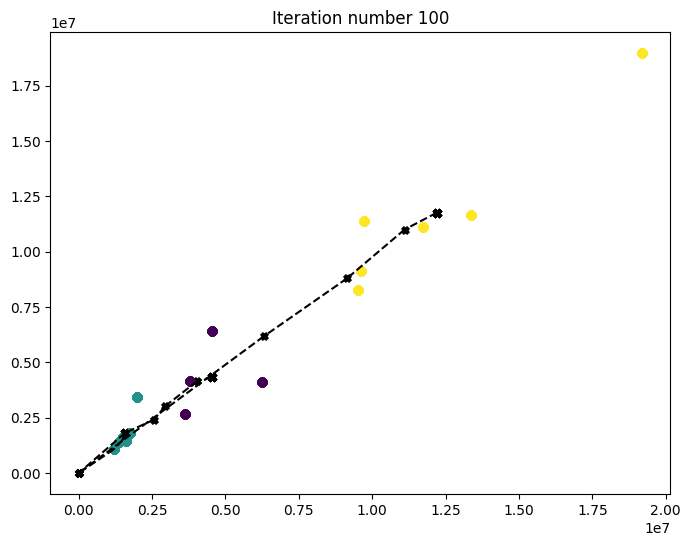

In [153]:
# Load an example dataset
X = load_data('clean_data.json')

# Set initial centroids
initial_centroids = np.array([[3, 3, 3], [6, 2, 2], [8, 5, 5]])

# Number of iterations
max_iters = 100

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

In [154]:
def kMeans_init_centroids(X, K):
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K]]

    return centroids

K-Means iteration 0/99
K-Means iteration 1/99
K-Means iteration 2/99
K-Means iteration 3/99
K-Means iteration 4/99


<ipython-input-151-59d450833520>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', K) # Get the colormap object and assign it to cmap


K-Means iteration 5/99
K-Means iteration 6/99
K-Means iteration 7/99
K-Means iteration 8/99
K-Means iteration 9/99
K-Means iteration 10/99
K-Means iteration 11/99
K-Means iteration 12/99
K-Means iteration 13/99
K-Means iteration 14/99
K-Means iteration 15/99
K-Means iteration 16/99
K-Means iteration 17/99
K-Means iteration 18/99
K-Means iteration 19/99
K-Means iteration 20/99
K-Means iteration 21/99
K-Means iteration 22/99
K-Means iteration 23/99
K-Means iteration 24/99
K-Means iteration 25/99
K-Means iteration 26/99
K-Means iteration 27/99
K-Means iteration 28/99
K-Means iteration 29/99
K-Means iteration 30/99
K-Means iteration 31/99
K-Means iteration 32/99
K-Means iteration 33/99
K-Means iteration 34/99
K-Means iteration 35/99
K-Means iteration 36/99
K-Means iteration 37/99
K-Means iteration 38/99
K-Means iteration 39/99
K-Means iteration 40/99
K-Means iteration 41/99
K-Means iteration 42/99
K-Means iteration 43/99
K-Means iteration 44/99
K-Means iteration 45/99
K-Means iteration 46/

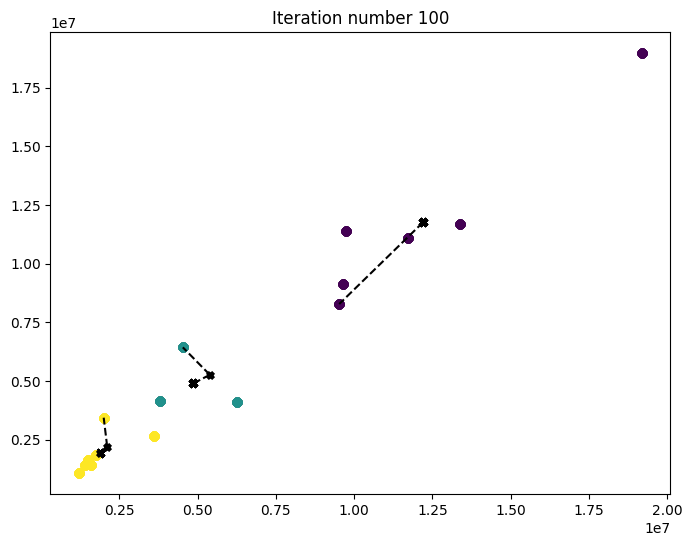

In [155]:
# Set number of centroids and max number of iterations
K = 3
max_iters = 100

# Set initial centroids by picking random examples from the dataset
initial_centroids = kMeans_init_centroids(X, K)

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)